# MATH 497: Final Project

Remark: 

Please upload your solutions for this project to Canvas with a file named "Final_Project_yourname.ipynb".

=================================================================================================================

## Problem 1 [20%]:  

Consider the following linear system

\begin{equation}\label{matrix}
A\ast u =f,
\end{equation}
or equivalently $u=\arg\min \frac{1}{2} (A* v,v)_F-(f,v)_F$, where $(f,v)_F =\sum\limits_{i,j=1}^{n}f_{i,j}v_{i,j}$ is the Frobenius inner product.
Here $\ast$ represents a convolution with one channel, stride one and zero padding one. The convolution kernel $A$ is given by
$$ 
A=\begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix},~~
$$
the solution $ u \in \mathbb{R}^{n\times n} $, and the RHS $ f\in \mathbb{R}^{n\times n}$ is given by $f_{i,j}=\dfrac{1}{(n+1)^2}.$


### Tasks:
Set $J=4$, $n=2^J-1$ and the number of iterations $M=100$. Use the gradient descent method and the multigrid method to solve the above problem with a random initial guess $u^0$. Let $u_{GD}$ and $u_{MG}$ denote the solutions obtained by gradient descent and multigrid respectively.
    
* [5%] Plot the surface of solution $u_{GD}$ and $u_{MG}$.

* [10%] Define error $e_{GD}^m = \|A * u^{m}_{GD}- f\|_F=\sqrt{\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n} |(A * u^{m}_{GD}- f)_{i,j}}|^2 $ for $m=0,1,2,3,...,M$. Similarly, we define the multigrid error $e_{MG}^m$. Plot the errors $e_{GD}^m$ and $e_{MG}^m$ as a function of the iteration $m$ (your x-axis is $m$ and your y-axis is the error). Put both plots together in the same figure.

* [5%] Find the minimal $m_1$ for which $e^{m_1}_{GD} <10^{-5}$ and the minimal $m_2$ for which $e^{m_2}_{MG} <10^{-5}$, and report the computational time for each method. Note that $m_1$ or $m_2$ may be greater than $M=100$, in this case you will have to run more iterations.

### Remark:

Below are examples of using gradient descent and multigrid iterations for M-times 
* #### For gradient descent method with $\eta=\frac{1}{8}$, you need to write a code:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~\text{for    }  i,j = 1: n\\
&~~~~~~~~u_{i,j}^{m} = u_{i,j}^{m-1}-\eta(f_{i,j}-(A\ast u^{m-1})_{i,j})\\
&~~~~\text{endfor}\\
&\text{endfor}
\end{align} 
$$

* #### For multigrid method, we have provided the framework code in F02_MultigridandMgNet.ipynb:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~u^{m} = MG1(u^{m-1},f, J, \nu)\\
&\text{endfor}
\end{align} 
$$

Use GPU? True
Problem 1 Task (a): Plot the surface of solution.
Problem 1 Task (b): Plot the errors of solution.


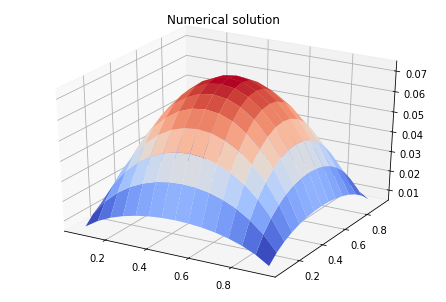

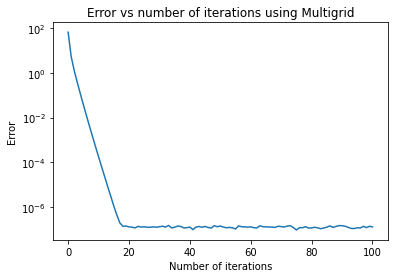

In [18]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

    
##### For MG: inilization of A, S, Pi, R, RT #####
def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)
    
    return


##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####

        self.A = A
        self.S = S
    
    def forward(self, out):
        u, f = out
        u = u + (self.S(((f-self.A(u)))))                                   ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####
        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####     
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u    

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)              
                
                layers= [MgRestriction(A_old, A, Pi, R)]


    def forward(self, u, f):
        
        out = (u, f) 

        u_list.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####
        
        return u


def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)

    
def plot_error(M,error,label_name):
    #print(np.linalg.norm((f-self.A(u)).reshape(-1).detach().numpy()))
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plot = plt.plot(error)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()


def MG1(u,f,J,num_iteration):
    u_list.clear()                                     # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f)
    for j in range(J-1,0,-1):
        u_list[j] += RT(u_list[j+1])
    u = u_list[1]
    return u


# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 
num_iteration = [2,2,2,2]
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

##### For MG: PDE setup u=sin(2*pi*x)*sin(2*pi*y) #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Muligrid iteration #####
M = 100
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]  # calculate the Frobenius Norm of (A*u-f)
u_list =[]                                     # Save u^0,u^1,u^2,u^3...,u^J

for m in range(M):
    u = MG1(u,f,J,num_iteration)
    error.append(np.linalg.norm((A(u)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)


##### Lian added for MG: Plot results #####
print("Problem 1 Task (a): Plot the surface of solution.")
plot_solution(J,u,'Numerical solution')

print("Problem 1 Task (b): Plot the errors of solution.")
plot_error(M,error,'Multigrid')

=================================================================================================================

## Problem 2 [50%]: 

Use SGD with momentum and weight decay to train MgNet on the Cifar10 dataset. Use 120 epochs, set the initial learning rate to 0.1, momentum to 0.9, weight decay to 0.0005, and divide the learning rate by 10 every 30 epochs. (The code to do this has been provided.) Let $b_i$ denote the test accuracy of the model after $i$ epochs, and let $b^*$ = $\max_i(b_i)$ be the best test accuracy attained during training.


### Tasks:
   * [30%] Train MgNet with the following three sets of hyper-parameters (As a reminder, the hyper-parameters of MgNet are $\nu$, the number of iterations of each layer, $c_u$, the number of channels for $u$, and $c_f$, the number of channels for $f$.):
 
    (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
    
    (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

    (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, try to improve the test accuracy by implementing MgNet with $S^{l,i}$, which means different iterations in the same layer do not share the same $S^{l}$. 
  
  
   * For each numerical experiment above, print the results with the following format:

       "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

        where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.
    
    
   * [10%] For each numerical experiment above, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. An example plot is shown in the next cell.
   
   
   * [10%] Calculate the number of parameters that each of the above models has. Discuss why the number of parameters is different (or the same) for each of the models.
       

Use GPU? True
Problem 2 task (1): v=[1,1,1,1], cu=cf=64
Part a:
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.56444, the test accuracy: 0.5677
Epoch: 2, learning rate: 0.1, the training accuracy: 0.61602, the test accuracy: 0.6146
Epoch: 3, learning rate: 0.1, the training accuracy: 0.68202, the test accuracy: 0.6669
Epoch: 4, learning rate: 0.1, the training accuracy: 0.69334, the test accuracy: 0.683
Epoch: 5, learning rate: 0.1, the training accuracy: 0.73982, the test accuracy: 0.7267
Epoch: 6, learning rate: 0.1, the training accuracy: 0.77678, the test accuracy: 0.7725
Epoch: 7, learning rate: 0.1, the training accuracy: 0.72788, the test accuracy: 0.7211
Epoch: 8, learning rate: 0.1, the training accuracy: 0.73644, the test accuracy: 0.7291
Epoch: 9, learning rate: 0.1, the training accuracy: 0.74144, the test accuracy: 0.7341
Epoch: 10, learning rate: 0.1, the training accuracy: 0.7554, the tes

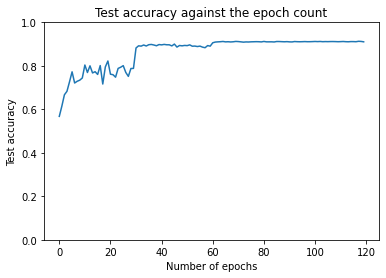


Part c: model size: 520394


In [ ]:
# from IPython.display import Image
# Image(filename='plot_sample_code.png')

import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 30 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

print("Problem 2 task (1): v=[1,1,1,1], cu=cf=64")
print("Part a:")
num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10
num_iteration = [1,1,1,1]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

end = timer()
print('Total Computation Time:',end - start)

# Part b: plot test accuracy
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)


# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

Use GPU? True
Problem 2 task (2): v=[2,2,2,2], cu=cf=64
Part a:
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.42768, the test accuracy: 0.4251
Epoch: 2, learning rate: 0.1, the training accuracy: 0.51066, the test accuracy: 0.503
Epoch: 3, learning rate: 0.1, the training accuracy: 0.64052, the test accuracy: 0.6374
Epoch: 4, learning rate: 0.1, the training accuracy: 0.6265, the test accuracy: 0.6184
Epoch: 5, learning rate: 0.1, the training accuracy: 0.74922, the test accuracy: 0.7363
Epoch: 6, learning rate: 0.1, the training accuracy: 0.74068, the test accuracy: 0.7315
Epoch: 7, learning rate: 0.1, the training accuracy: 0.77846, the test accuracy: 0.7574
Epoch: 8, learning rate: 0.1, the training accuracy: 0.7921, the test accuracy: 0.7792
Epoch: 9, learning rate: 0.1, the training accuracy: 0.7762, the test accuracy: 0.7756
Epoch: 10, learning rate: 0.1, the training accuracy: 0.74852, the test 

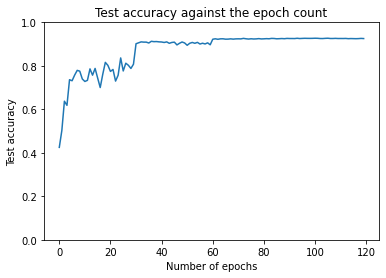


Part c: model size: 521418


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 30 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

print("Problem 2 task (2): v=[2,2,2,2], cu=cf=64")
print("Part a:")
num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

end = timer()
print('Total Computation Time:',end - start)

# Part b: plot test accuracy
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)


# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

Use GPU? True
Problem 2 task (3): v=[2,2,2,2], cu=cf=64, with S^l,i
Part a:
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.52454, the test accuracy: 0.5281
Epoch: 2, learning rate: 0.1, the training accuracy: 0.5756, the test accuracy: 0.573
Epoch: 3, learning rate: 0.1, the training accuracy: 0.71116, the test accuracy: 0.7034
Epoch: 4, learning rate: 0.1, the training accuracy: 0.71518, the test accuracy: 0.7023
Epoch: 5, learning rate: 0.1, the training accuracy: 0.7309, the test accuracy: 0.7193
Epoch: 6, learning rate: 0.1, the training accuracy: 0.7236, the test accuracy: 0.7058
Epoch: 7, learning rate: 0.1, the training accuracy: 0.7474, the test accuracy: 0.7359
Epoch: 8, learning rate: 0.1, the training accuracy: 0.73764, the test accuracy: 0.7265
Epoch: 9, learning rate: 0.1, the training accuracy: 0.74372, the test accuracy: 0.7263
Epoch: 10, learning rate: 0.1, the training accuracy: 0.75276

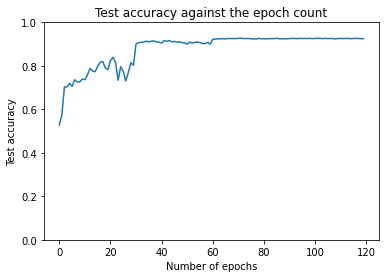


Part c: model size: 668874


In [2]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):

                # Try to improve the test accuracy by implementing MgNet with S^l,i
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 30 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

print("Problem 2 task (3): v=[2,2,2,2], cu=cf=64, with S^l,i")
print("Part a:")
num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

end = timer()
print('Total Computation Time:',end - start)

# Part b: plot test accuracy
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)


# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

=================================================================================================================

## Problem 3 [25 %]:

Try to improve the MgNet Accuracy by increasing the number of channels. (We use the same notation as in the previous problem.) Double the number of channels to $c_u=c_f=128$ and try different $\nu$ to maximize the test accuracy.

### Tasks:
   * [20%] Report $b^{*}$, $\nu$ and the number of parameters of your model for each of the experiments you run.
   * [5%] For the best experiment, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. (Same as for the previous problem.)

Use GPU? True
Problem 3 task (1): v=[1,1,1,1], cu=cf=128
Part a:
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.50154, the test accuracy: 0.492
Epoch: 2, learning rate: 0.1, the training accuracy: 0.67294, the test accuracy: 0.6642
Epoch: 3, learning rate: 0.1, the training accuracy: 0.67138, the test accuracy: 0.6629
Epoch: 4, learning rate: 0.1, the training accuracy: 0.7346, the test accuracy: 0.7257
Epoch: 5, learning rate: 0.1, the training accuracy: 0.75746, the test accuracy: 0.7387
Epoch: 6, learning rate: 0.1, the training accuracy: 0.72134, the test accuracy: 0.7181
Epoch: 7, learning rate: 0.1, the training accuracy: 0.7693, the test accuracy: 0.7363
Epoch: 8, learning rate: 0.1, the training accuracy: 0.81222, the test accuracy: 0.7966
Epoch: 9, learning rate: 0.1, the training accuracy: 0.8007, the test accuracy: 0.7976
Epoch: 10, learning rate: 0.1, the training accuracy: 0.80186, the test

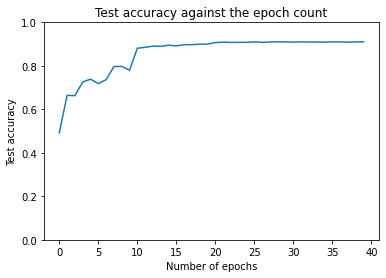

Total Computation Time: 2530.5128443110007

Part c: model size: 2072970


In [10]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 10 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 10)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 40
lr = 0.1

print("Problem 3 task (1): v=[1,1,1,1], cu=cf=128")
print("Part a:")
num_channel_input = 3
num_channel_u = 128
num_channel_f = 128
num_classes = 10
num_iteration = [1,1,1,1]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

# Part b: plot test accuracy
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)

end = timer()
print('Total Computation Time:',end - start)

# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

Use GPU? True
Problem 3 task (2): v=[2,2,2,2], cu=cf=128
Part a:
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.4373, the test accuracy: 0.4358
Epoch: 2, learning rate: 0.1, the training accuracy: 0.60156, the test accuracy: 0.5873
Epoch: 3, learning rate: 0.1, the training accuracy: 0.5596, the test accuracy: 0.5422
Epoch: 4, learning rate: 0.1, the training accuracy: 0.6919, the test accuracy: 0.6755
Epoch: 5, learning rate: 0.1, the training accuracy: 0.72998, the test accuracy: 0.7068
Epoch: 6, learning rate: 0.010000000000000002, the training accuracy: 0.86244, the test accuracy: 0.8456
Epoch: 7, learning rate: 0.010000000000000002, the training accuracy: 0.87312, the test accuracy: 0.8543
Epoch: 8, learning rate: 0.010000000000000002, the training accuracy: 0.88326, the test accuracy: 0.8596
Epoch: 9, learning rate: 0.010000000000000002, the training accuracy: 0.8877, the test accuracy: 0.8632
Epo

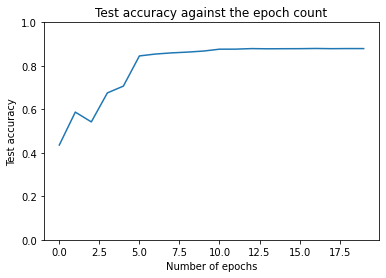

Total Computation Time: 1818.0774734410006

Part c: model size: 2075018


In [11]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 5 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 5)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 20
lr = 0.1

print("Problem 3 task (2): v=[2,2,2,2], cu=cf=128")
print("Part a:")
num_channel_input = 3
num_channel_u = 128
num_channel_f = 128
num_classes = 10
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

# Part b: plot test accuracy
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)

end = timer()
print('Total Computation Time:',end - start)

# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

In [3]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):

                # Try to improve the test accuracy by implementing MgNet with S^l,i
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 30 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

print("Problem 3 task (3): v=[2,2,2,2], cu=cf=128, with S^l,i")
print("Part a:")
num_channel_input = 3
num_channel_u = 128
num_channel_f = 128
num_classes = 10
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

end = timer()
print('Total Computation Time:',end - start)

Use GPU? True
Problem 3 task (3): v=[2,2,2,2], cu=cf=128, with S^l,i
Part a:
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.4819, the test accuracy: 0.494
Epoch: 2, learning rate: 0.1, the training accuracy: 0.50622, the test accuracy: 0.5239
Epoch: 3, learning rate: 0.1, the training accuracy: 0.62284, the test accuracy: 0.5991
Epoch: 4, learning rate: 0.1, the training accuracy: 0.69404, the test accuracy: 0.6896
Epoch: 5, learning rate: 0.1, the training accuracy: 0.70426, the test accuracy: 0.6965
Epoch: 6, learning rate: 0.1, the training accuracy: 0.80528, the test accuracy: 0.7922
Epoch: 7, learning rate: 0.1, the training accuracy: 0.7578, the test accuracy: 0.7429
Epoch: 8, learning rate: 0.1, the training accuracy: 0.77944, the test accuracy: 0.772
Epoch: 9, learning rate: 0.1, the training accuracy: 0.7896, the test accuracy: 0.7822
Epoch: 10, learning rate: 0.1, the training accuracy: 0.8030


Part b: plot test accuracy


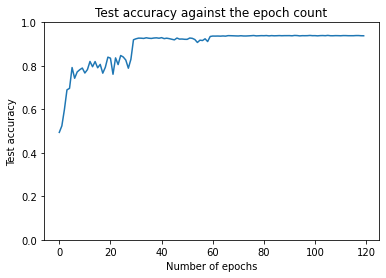


Part c: model size: 2075018


In [12]:
# Part b: plot test accuracy
accuracy_history = [0.494, 0.5239, 0.5991, 0.6896, 0.6965, 0.7922, 0.7429, 0.772, 0.7822, 0.7899, 0.767, 0.7827, 0.8202, 0.796, 0.8197, 
                    0.7911, 0.8066, 0.7663, 0.7934, 0.84, 0.8354, 0.7613, 0.8366, 0.8058, 0.8475, 0.8408, 0.8267, 0.7891, 0.8302, 0.9199, 
                    0.9245, 0.9275, 0.9272, 0.9261, 0.9291, 0.927, 0.9261, 0.928, 0.9288, 0.927, 0.9297, 0.9252, 0.9272, 0.9251, 0.9223, 
                    0.9195, 0.9279, 0.923, 0.9234, 0.9221, 0.9219, 0.928, 0.9265, 0.921, 0.9075, 0.9181, 0.9165, 0.9244, 0.9118, 0.9351, 
                    0.937, 0.9368, 0.9371, 0.9366, 0.9375, 0.9366, 0.9389, 0.9386, 0.9382, 0.9377, 0.9374, 0.9384, 0.9374, 0.9373, 0.9379, 
                    0.9386, 0.9395, 0.9378, 0.9383, 0.9389, 0.9386, 0.9393, 0.9378, 0.939, 0.9382, 0.9385, 0.9391, 0.9385, 0.9389, 0.9389, 
                    0.9390, 0.9382, 0.9398, 0.9393, 0.9378, 0.9388, 0.9386, 0.9388, 0.9398, 0.9387, 0.9389, 0.938, 0.939, 0.9393, 0.9386, 
                    0.94, 0.9385, 0.9384, 0.939, 0.9388, 0.9384, 0.9392, 0.9391, 0.9386, 0.9386, 0.9386, 0.9393, 0.9393, 0.9385, 0.9383]
print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)

# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

=================================================================================================================

## Problem 4 [5%]:

Continue testing larger MgNet models (i.e. increase the number of channels) to maximize the test accuracy. (Again, we use the same notation as in problem 2.)

### Tasks:    
    
+  [5%] Try different training strategies and MgNet architectures with the goal of achieving $b^*>$ 95%. Hint: you can tune the number of epochs, the learning rate schedule, $c_u$, $c_f$, $\nu$, try different $S^{l,i}$ in the same layer $l$, etc...

Use GPU? True
Problem 4: v=[2,2,2,2], cu=cf=128, with S^l,i
Part a:
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.46436, the test accuracy: 0.4563
Epoch: 2, learning rate: 0.1, the training accuracy: 0.62272, the test accuracy: 0.6171
Epoch: 3, learning rate: 0.1, the training accuracy: 0.68662, the test accuracy: 0.6821
Epoch: 4, learning rate: 0.1, the training accuracy: 0.72792, the test accuracy: 0.7288
Epoch: 5, learning rate: 0.1, the training accuracy: 0.79268, the test accuracy: 0.7791
Epoch: 6, learning rate: 0.1, the training accuracy: 0.69168, the test accuracy: 0.6914
Epoch: 7, learning rate: 0.1, the training accuracy: 0.80214, the test accuracy: 0.7859
Epoch: 8, learning rate: 0.1, the training accuracy: 0.75222, the test accuracy: 0.7316
Epoch: 9, learning rate: 0.1, the training accuracy: 0.76322, the test accuracy: 0.7503
Epoch: 10, learning rate: 0.1, the training accuracy: 0.7804, th

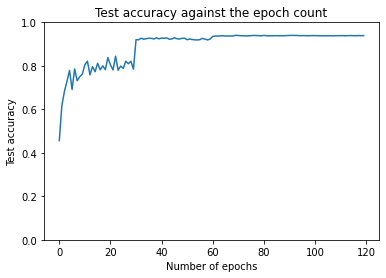


Part c: model size: 2664842


In [19]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S
        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):

                # Try to improve the test accuracy by implementing MgNet with S^l,i
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        out = (u, f)

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out)
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

# Divide the learning rate by 10 every 30 epochs
def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

print("Problem 4: v=[2,2,2,2], cu=cf=128, with S^l,i")
print("Part a:")
num_channel_input = 3
num_channel_u = 128
num_channel_f = 128
num_classes = 10
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])
transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)
start = timer()

accuracy_history = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    accuracy_history.append(test_accuracy)

end = timer()
print('Total Computation Time:',end - start)

print("\nPart b: plot test accuracy")
def plot_accuracy(num_epochs,accuracy_history):
    plt.figure()
    plt.title('Test accuracy against the epoch count')
    plot = plt.plot(accuracy_history)
    plt.xlabel('Number of epochs')
    plt.ylim(0, 1)
    plt.ylabel('Test accuracy')
    plt.show()
plot_accuracy(num_epochs, accuracy_history)

# Calculate model size
model_size = sum(param.numel() for param in my_model.parameters())
print("\nPart c: model size:", model_size)

=================================================================================================================